# This notebook demostrates how to load and use an exsit GPR model generrated by Gpy.
# Before runing this notebook, please install Gpy with the following command:

With anaconda you can install GPy by the following:

conda update scipy

Then potentially try,

sudo apt-get update
sudo apt-get install python3-dev
sudo apt-get install build-essential   
conda update anaconda

And finally,

pip install gpy

We've also had luck with enthought. Install scipy 1.3.0 (or later) and then pip install GPy:

pip install gpy

For more infomation, please go to the Gpy homepage on GitHub https://github.com/SheffieldML/GPy

In [59]:
import GPy
import pickle
import numpy as np
import matplotlib #
from numpy import *
from matplotlib import *
import pandas as pd
import warnings
import glob
import random
import time
import re
import os, sys
import csv
import seaborn as sns
#import corner



# The lines below are specific to the notebook format
textsize = 25

%matplotlib inline 

params = {'legend.fontsize': textsize,
          'figure.figsize': (12, 10),
         'axes.labelsize': textsize,
         'axes.titlesize':textsize,
         'xtick.labelsize':textsize,
         'ytick.labelsize':textsize,
         'font.size': textsize}
matplotlib.rcParams.update(params)
plt = matplotlib.pyplot



# Set up path where you save the folder

In [60]:
datapath = '/Users/litz/Documents/GitHub/GPGrid/paper_used/2D_fun_to_obs/gpmodel_example/'

In [61]:
if not os.path.exists(datapath):
    raise Warning(f'path:' + workpath + ' does not exist')
training_data = pd.read_csv(workpath + 'gpm.csv')
model_parameter = workpath + 'gpm.npy'
validation_data1 = pd.read_csv(workpath + 'dfv_ongrid.csv')
validation_data2 = pd.read_csv(workpath + 'dfv_offgrid.csv')

In [62]:
training_data.columns

Index(['Unnamed: 0', 'evol_stage', 'initial_mass', 'initial_Yinit',
       'initial_feh', 'initial_MLT', 'star_age', 'frac_age', 'ms_age',
       'effective_T', 'log_g', 'radius', 'star_feh', 'delta_nu_fit',
       'hrgradient', 'fagegradient', 'initial_zx', 'star_zx'],
      dtype='object')

# we can make some plots to inspect the data set

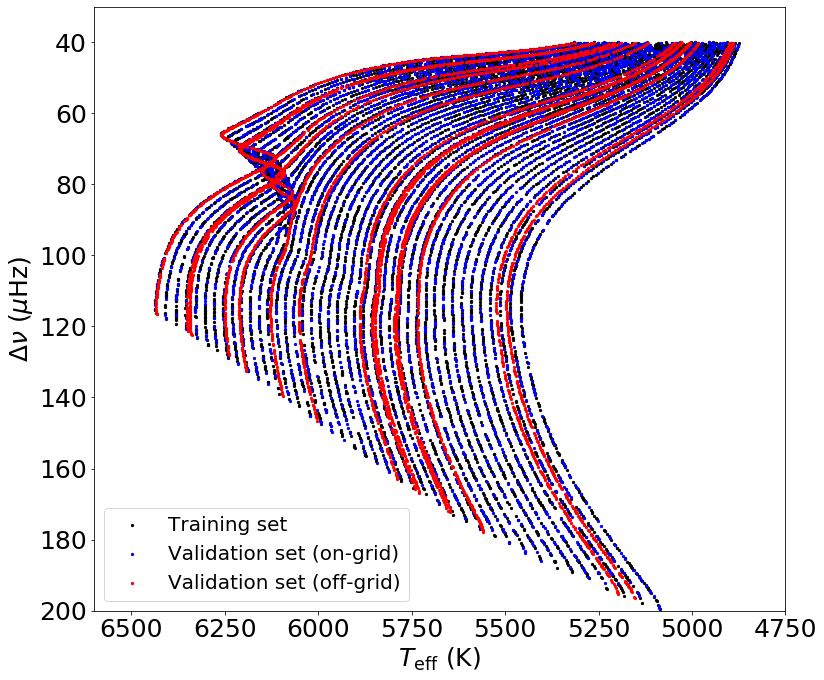

In [63]:
# Like inpecting data on HRD
fig, ax1 = plt.subplots(1,1)
cp = ax1.scatter(training_data['effective_T'], training_data['delta_nu_fit'], 
                 c = 'k',s = 5, label = 'Training set') 
ax1.scatter(validation_data1['effective_T'], validation_data1['delta_nu_fit'], 
            c = 'b',s = 5, label = 'Validation set (on-grid)') 
ax1.scatter(validation_data2['effective_T'], validation_data2['delta_nu_fit'], 
            c = 'r',s = 5, label = 'Validation set (off-grid)') 
ax1.set_xlabel(r'$T_{\rm eff}$ (K)')
ax1.set_ylabel(r'$\Delta\nu$ ($\mu$Hz)')
ax1.set_xlim([6600,4750])
ax1.set_ylim([200,30])
ax1.legend(fontsize = 20)
fig.tight_layout()
#fig.savefig(gmk._savepath + '2d_data_on_HR.pdf')
#ax1.set_title('MESA grid models')

# let us load a Gpy model
A Gpy model is saved as tow parts, one is the training data ('gpm.csv'), the other is the model parameters ('gpm.npy'). Loading a model requires the script which creates the model. Then, you can create the model using initialize=False as a keyword argument and with the data loaded as normal. You then set the model parameters by setting m.param_array[:] = loaded_params as the previously saved parameters. Then you initialize the model by m.initialize_parameter(), which will make the model usable. Be aware that up to this point the model is in an inconsistent state and cannot be used to produce any results. (https://github.com/SheffieldML/GPy)

In [64]:
# Here we copy the script which create the model, load the training data and the model parameter with the following script. 
def load_a_mlp_gpm(df = None, npy = None, xcolumns = None, ycolumns = None):
    nx = len(xcolumns)
    ny = len(ycolumns)

    if (nx>1):
        xx = df[xcolumns].to_numpy()
    else:
        xx = df[xcolumns].to_numpy().reshape(-1,1)
        
    if (ny > 1):
        yy = df[ycolumns].to_numpy()
    else:
        yy = df[ycolumns].to_numpy().reshape(-1,1)

    kernel = GPy.kern.MLP(input_dim=nx, ARD = True)
            
    m_load = GPy.models.GPRegression(xx,yy,kernel,initialize=False)
    m_load.update_model(False) # do not call the underlying expensive algebra on load
    m_load.initialize_parameter() # Initialize the parameters (connect the parameters up)
    m_load[:] = np.load(npy) # Load the parameters
    m_load.update_model(True) # Call the algebra only once
    return m_load

In [65]:
# xcolumns are inputs, ycolumns are outputs. In this example our model has two inputs and six outputs.
xcolumns = ['initial_mass', 'frac_age']
ycolumns = ['effective_T','log_g','radius', 'star_age','star_zx', 'delta_nu_fit']

gpm = load_a_mlp_gpm(df = training_data, npy = model_parameter, xcolumns = xcolumns, ycolumns = ycolumns)
print(gpm)

 /opt/anaconda3/lib/python3.7/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!



Name : GP regression
Objective : 68154.193824857
Number of Parameters : 5
Number of Optimization Parameters : 5
Updates : True
Parameters:
  GP_regression.           |                 value  |  constraints  |  priors
  mlp.variance             |    40728.157544811795  |      +ve      |        
  mlp.weight_variance      |                  (2,)  |      +ve      |        
  mlp.bias_variance        |    19544.600944081136  |      +ve      |        
  Gaussian_noise.variance  |  0.060561049676129394  |      +ve      |        


# The model is loaded, to quickly check weather the model is correct, we can use the model to predict the training data see if predictions match the original data. 

In [66]:
#Here is a function to GP a pandas dataframe
def sample_with_df(n = None, df = None, gpm = None, 
                   xcolumns = None, xshift = None, randomshift = None, 
                   ycolumns = None):
    nx = len(xcolumns)
    ny = len(ycolumns)
        
    df2 = df.copy()
    if (len(df2) < n):
        for i in range(100):
            df2 = pd.concat([df2, df])
            if len(df2)>n: break
        
    df2.index = range(len(df2))
        
    ndf = len(df2)
        
    for name in xcolumns:
        index = xcolumns.index(name)
        if (randomshift == True):
            df2[name] = df2[name] + xshift[index]*(np.random.random(len(df2[name]))-0.5)
        else:
            df2[name] = df2[name] + xshift[index]
        
    if (nx>1):
        xx = df2[xcolumns].to_numpy()
    else:
        xx = df2[xcolumns].to_numpy().reshape(-1,1)
        
    gpp = gpm.predict(xx)
    df2[ycolumns] = gpp[0]
    df2['gp_var'] = gpp[1].reshape(ndf,)
    return df2

In [67]:
predictions = sample_with_df(n = len(training_data), df = training_data, gpm = gpm, 
                                   xcolumns = xcolumns, xshift = [0.00,0.00], 
                                   randomshift = False, ycolumns = ycolumns)

Text(0.5, 1.0, 'offesets in training data')

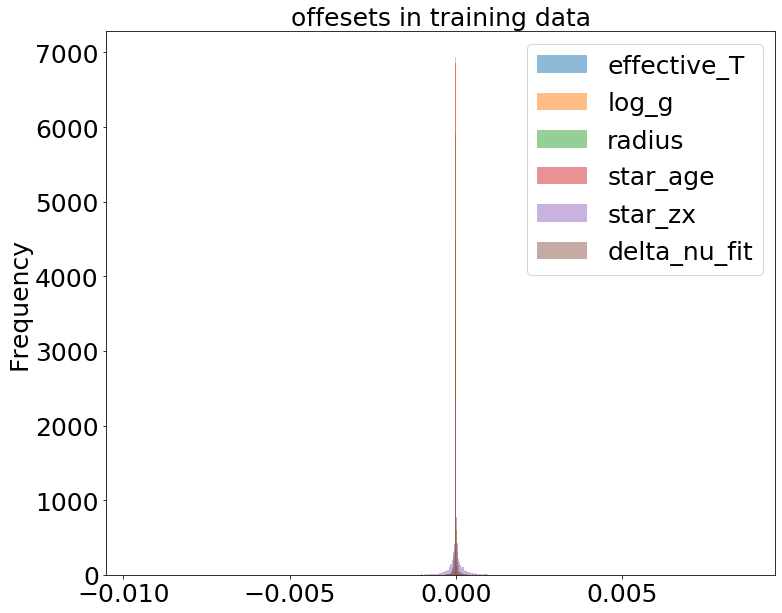

In [68]:
# let us compare the ycolumns of predictions and training data. 
#it can be seen that the differences are small, so we have load the model properly.
offsets = (training_data[ycolumns] - predictions[ycolumns])/training_data[ycolumns]
ax = offsets.plot.hist(bins=1000, alpha=0.5)
ax.set_title('offesets in training data')

# We can also use the above function to check the validation errors.

Text(0.5, 1.0, 'offesets in validation data (off-grid)')

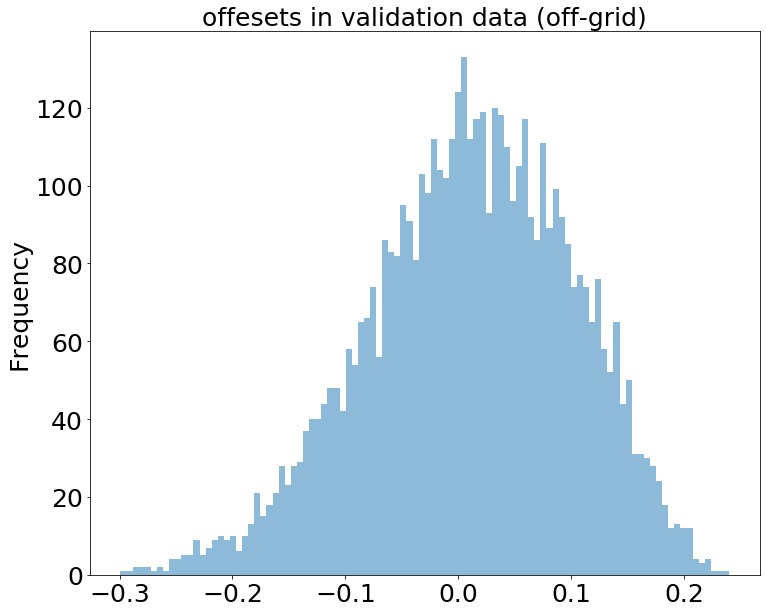

In [69]:
# this is an example for Teff
predictions = sample_with_df(n = len(validation_data2), df = training_data, gpm = gpm, 
                                   xcolumns = xcolumns, xshift = [0.00,0.00], 
                                   randomshift = False, ycolumns = ycolumns)
offsets = (validation_data2['effective_T'] - predictions['effective_T'])/validation_data2['effective_T']
ax = offsets.plot.hist(bins=100, alpha=0.5)
ax.set_title('offesets in validation data (off-grid)')

# lastly, we can use the Gpy model to predict what we want.
# before predicting, we need to know the input ranges. As it shown below, our input ranges are mass from 0.8 to 1.2 and fractional age from 0 to 1. 

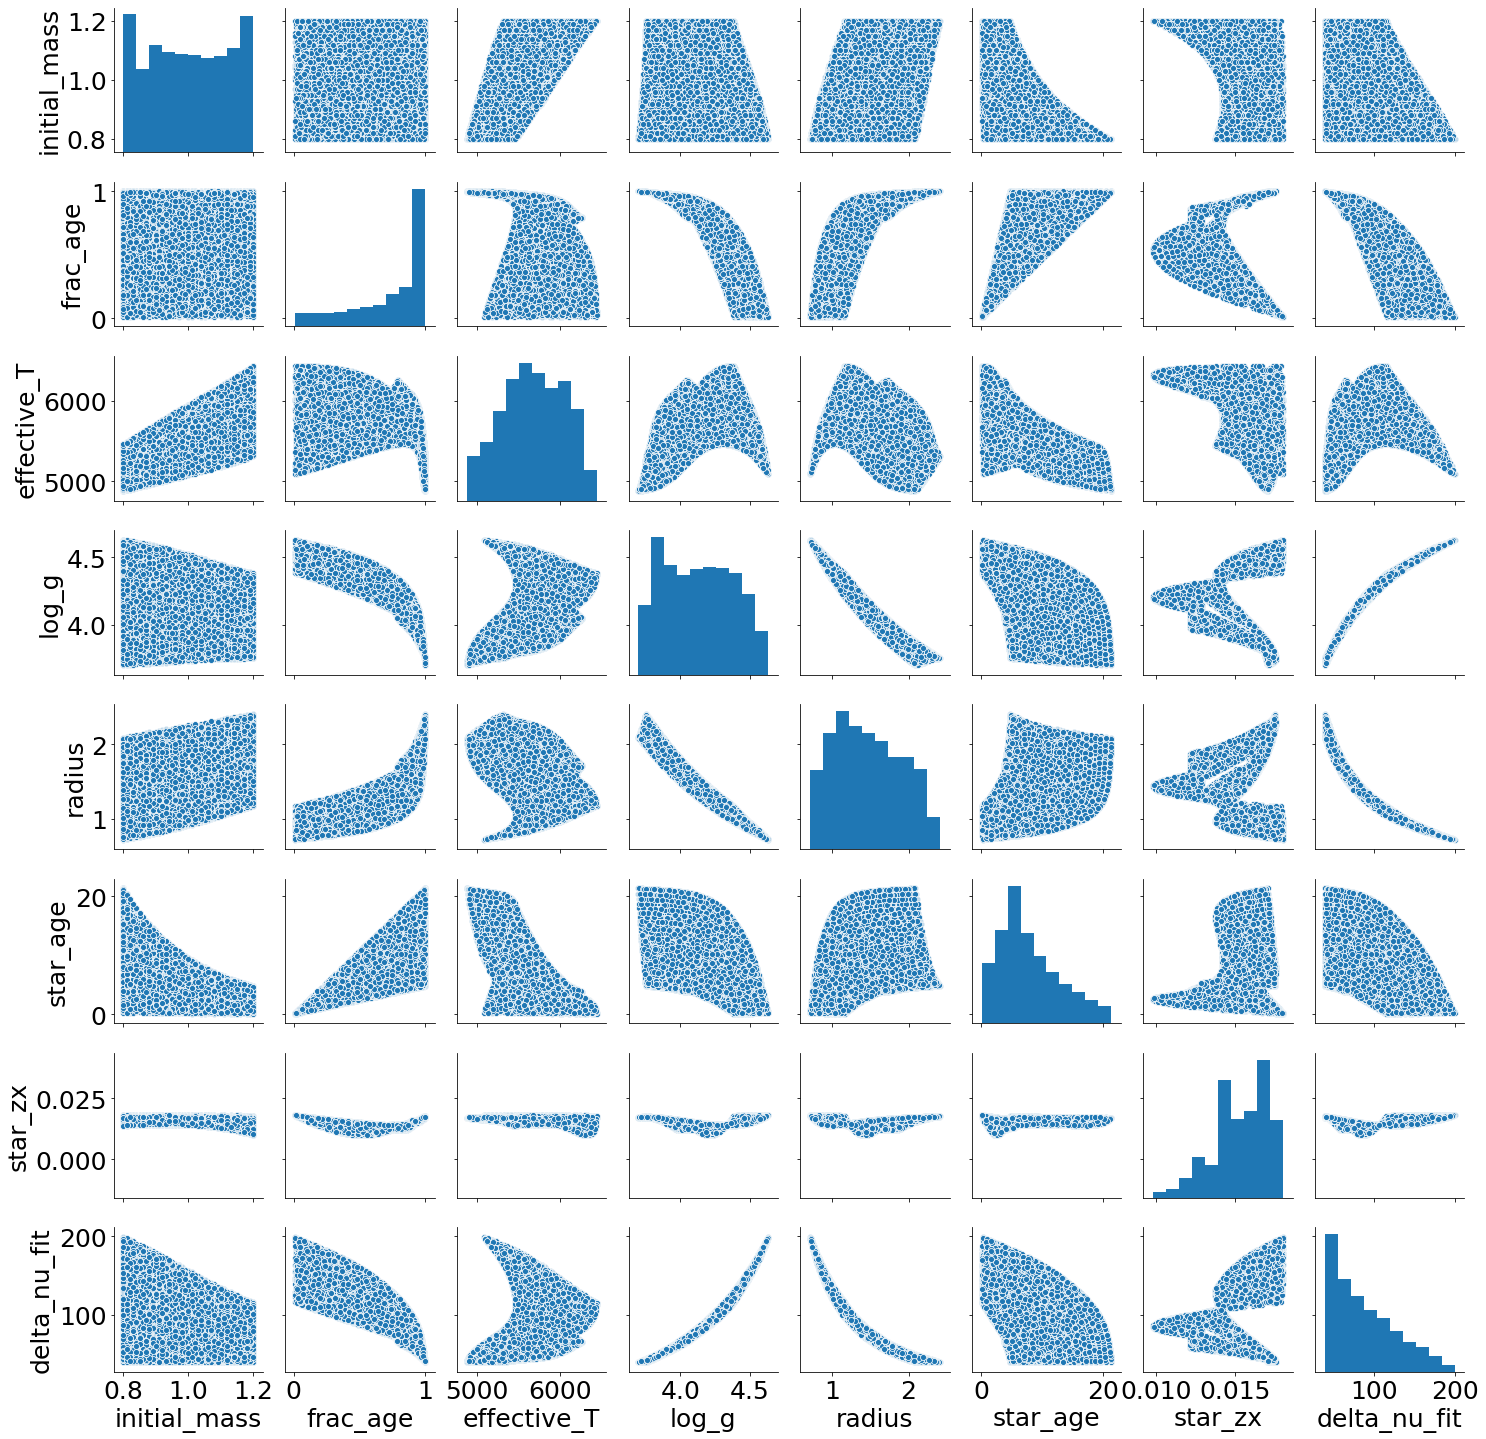

In [70]:
cc = ['initial_mass', 'frac_age','effective_T','log_g','radius', 'star_age','star_zx', 'delta_nu_fit']
sns.pairplot(training_data[cc])

# Now we can predict stellar parameters with given mass and frac_age

In [71]:
#make a np array and reshape it, here we try mass = 1.024, frac_age = 0.5
nshape = len(xcolumns)
inputs = np.array([1.024, 0.5]).reshape(-1,nshape)
# then gp is
gpp = gpm.predict(inputs)
gpp

(array([[6.00534020e+03, 4.34130721e+00, 1.13094367e+00, 4.35959931e+00,
         1.44842795e-02, 1.14153691e+02]]),
 array([[0.2050608]]))

# we can see that Gpy predictions contents two arrays, the first one is the output, the second is variance.

In [72]:
outputs = gpp[0]
outputs_var = gpp[1]

In [73]:
print(outputs)

[[6.00534020e+03 4.34130721e+00 1.13094367e+00 4.35959931e+00
  1.44842795e-02 1.14153691e+02]]


# so our outputs are effective_T = 6006K, log_g = 4.34, radius = 1.13, star_age = 4.36, star_zx = 0.0145, delta_nu_fit = 114.2

# Maybe ask Guy to write MCMC model... 